In [1]:
from sklearn.neural_network import BernoulliRBM
import numpy as np
import argparse
import time

In [2]:
def load_digits(datasetPath):
    # build the dataset and then split it into data
    # and labels
    X = np.genfromtxt(datasetPath, delimiter = ",", dtype = "uint8")
    y = X[:, 0]
    X = X[:, 1:]

    # return a tuple of the data and targets
    return (X, y)

def scale(X, eps = 0.001):
    # scale the data points s.t the columns of the feature space
    # (i.e the predictors) are within the range [0, 1]
    return (X - np.min(X, axis = 0)) / (np.max(X, axis = 0) + eps)

def nudge(X, y):
    # initialize the translations to shift the image one pixel
    # up, down, left, and right, then initialize the new data
    # matrix and targets
    translations = [(0, -1), (0, 1), (-1, 0), (1, 0)]
    data = []
    target = []

    # loop over each of the digits
    for (image, label) in zip(X, y):
        # reshape the image from a feature vector of 784 raw
        # pixel intensities to a 28x28 'image'
        image = image.reshape(28, 28)

        # loop over the translations
        for (tX, tY) in translations:
            # translate the image
            M = np.float32([[1, 0, tX], [0, 1, tY]])
            trans = cv2.warpAffine(image, M, (28, 28))

            # update the list of data and target
            data.append(trans.flatten())
            target.append(label)

    # return a tuple of the data matrix and targets
    return (np.array(data), np.array(target))

In [3]:
import os
import struct
import numpy as np

"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
        print(fname_img)
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

./train-images-idx3-ubyte
60000
5
(28, 28)


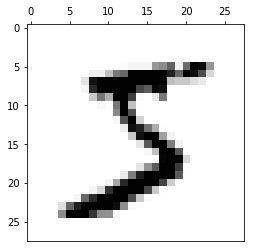

In [4]:
training_data_orig = list(read(dataset='training', path='.'))
print(len(training_data_orig))
label, pixels = training_data_orig[0]
print(label)
print(pixels.shape)
show(pixels)

In [5]:
def binarize(pic):
    temp = np.zeros(np.shape(pic))
    for row in range(len(pic)):
        for col in range(len(pic[0])):
            if pic[row][col] < (255.0 / 2):
                temp[row][col] = -1
            else: 
                temp[row][col] = 1
    return temp

In [6]:
training_data = training_data_orig[:500]
training_binarized = [(label, pixel) for label, pixel in training_data]
for i in range(len(training_data)):
    asdf = binarize(training_data[i][1])
    training_binarized[i] = (label, asdf)
# print(training_binarized)

In [7]:
training_noisy = training_binarized.copy()
# flip 16 values in each image
for i in range(len(training_binarized)):
    for count in range(16):
        row = np.random.randint(0,28)
        col = np.random.randint(0,28)
        training_noisy[i][1][row][col] = -1 * training_binarized[i][1][row][col]

In [ ]:
model = BernoulliRBM()
model.fit(training_noisy)